***Text Summerization : Classical and Transformer Based Appraches***

In [109]:
# Import Packages
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
import time

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
#load the data directories
train_data = pd.read_csv('/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/data/data_raw/data_train/cnn_train_data.csv')
test_data = pd.read_csv('/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/data/data_raw/data_test/cnn_test_data.csv')
val_data = pd.read_csv('/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/data/data_raw/data_validation/cnn_validation_data.csv')

#### **Exploratory Data Analysis**

In [4]:
train_data.describe()
train_data.head(5)

,Unnamed: 0,article,highlights,id
0,0,By . Daily Mail Reporter . PUBLISHED: . 04:03 ...,Lackland Air Force Base instructor Christopher...,aaa6237fb3dabcc34f95ad010c15d90a55c769c4
1,1,"By . Martin Robinson . PUBLISHED: . 10:45 EST,...",Leanne Zaloumis was found by the music mogul s...,57fc39ad6aadaf215f7bbedf3f5947d93a3dec60
2,2,"By . Luke Salkeld . UPDATED: . 07:48 EST, 16 N...",One was posted from Paris - three days after G...,0fd3a209c873fb5229ea4d752f486645002c03f9
3,3,"By . Helen Collis . PUBLISHED: . 13:47 EST, 3 ...",Alex Shirra was unconscious for 12 days after ...,c53e85eca2140700b5c3a522ac34eddceeda73b4
4,4,"By . David Baker . PUBLISHED: . 13:54 EST, 2 A...",Firebombing comes after man stormed reception ...,4324f10606dca366e937dfcb1453c6a9d5364151


In [5]:
test_data.describe()

,Unnamed: 0
count,11490.000000
mean,5744.500000
std,3317.021631
min,0.000000
25%,2872.250000
50%,5744.500000
75%,8616.750000
max,11489.000000


In [6]:
val_data.describe()

,Unnamed: 0
count,13368.000000
mean,6683.500000
std,3859.153534
min,0.000000
25%,3341.750000
50%,6683.500000
75%,10025.250000
max,13367.000000


In [7]:
# missing values
missing_values = train_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Unnamed: 0    0
article       0
highlights    0
id            0
dtype: int64


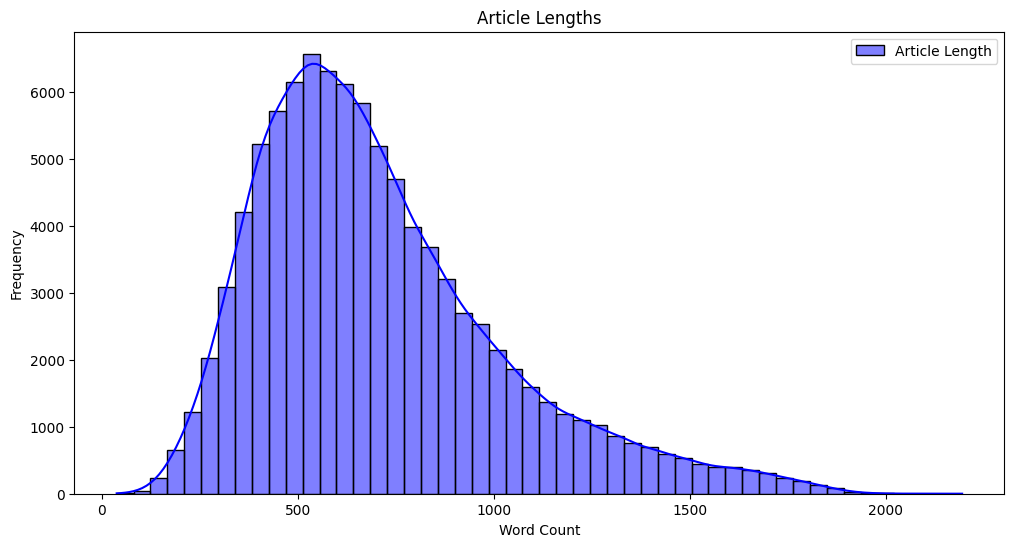

In [8]:
# length of each article and highlights
train_data['article_length'] = train_data['article'].apply(lambda x: len(x.split()))
# Plot distribution of article length
plt.figure(figsize=(12,6))
sns.histplot(train_data['article_length'], bins=50, kde=True, color='blue', label='Article Length')
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.title("Article Lengths")
plt.show()

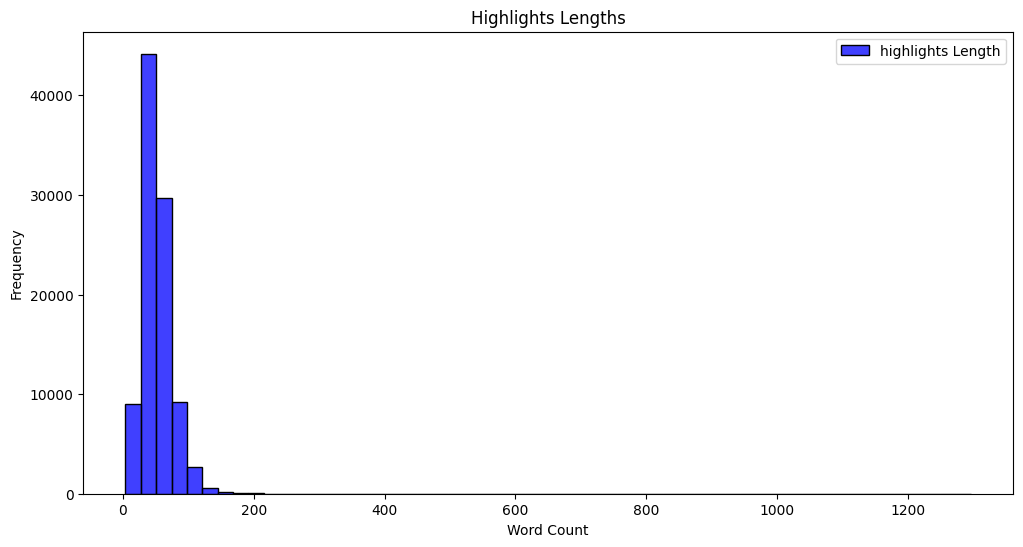

In [9]:
train_data['highlights_length'] = train_data['highlights'].apply(lambda x: len(x.split()))

# Highlights length
plt.figure(figsize=(12,6))
sns.histplot(train_data['highlights_length'], bins=55, color='blue',  label='highlights Length')
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.title("Highlights Lengths")
max_word_count = train_data['highlights_length'].max()
plt.xticks(np.arange(0, max_word_count + 1, 200))
plt.show()

In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# def plot_wordcloud(text, title):
#     wordcloud = WordCloud(width=800, height=400, stopwords=stop_words, background_color="white").generate(" ".join(text))
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(title)
#     plt.show()

# # Plot word clouds
# plot_wordcloud(train_data['article'], 'Word Cloud for Articles')
# plot_wordcloud(train_data['highlights'], 'Word Cloud for Summaries')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### **Data Preprocessing**

In [135]:
csv_path ='/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/data/data_raw/data_test/cnn_test_data.csv'

# load dataset
def load_cnn_daily_mail_dataset(csv_path):
    # Load data from CSV
    df = pd.read_csv(csv_path)

    # random  20 rows
    sample_df = df.sample(n=20, random_state=42)

    # Convert sample to a list of dictionaries with 'article' and 'highlights'
    data = sample_df[['article', 'highlights']].to_dict(orient='records')

    return data

In [136]:
data_samples = load_cnn_daily_mail_dataset(csv_path)
data_samples[0]['article']
example_article = data_samples[10]["article"]
original_summary = data_samples[10]["highlights"]

In [137]:
# Download NLTK stopwords
nltk.download("stopwords")
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [138]:
# Text Preprocessing
def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    # Removing stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [184]:
Inference_times={}

####  **Bag of Words**

In [185]:
# Bag of Words Summarization
def summarize_with_bow(article_text, num_sentences=5):
    # Split article into sentences
    sentences = nltk.sent_tokenize(article_text)
    # Preprocess sentences
    processed_sentences = [preprocess_text(sentence) for sentence in sentences]

    # Vectorize sentences using Bag of Words
    vectorizer = CountVectorizer()
    sentence_vectors = vectorizer.fit_transform(processed_sentences)

    # Compute similarity matrix
    similarity_matrix = cosine_similarity(sentence_vectors)

    # similarity score
    sentence_scores = similarity_matrix.sum(axis=1)
    ranked_sentences = np.argsort(sentence_scores)[::-1]

    # Select top sentences
    selected_sentences = [sentences[i] for i in ranked_sentences[:num_sentences]]
    summary = " ".join(selected_sentences)
    return summary

# Load dataset
data = load_cnn_daily_mail_dataset(csv_path)
example_article = data[1]["article"]

# Generate summary for an example article
start_time = time.time()
summary = summarize_with_bow(example_article)
end_time = time.time()
BoW_Inference_time = end_time - start_time
Inference_times['BoW'] = BoW_Inference_time
print(f"Time taken: {end_time - start_time} seconds")
# print("Original Article:", example_article)
print("Generated Summary:", summary)

Time taken: 0.005127668380737305 seconds
Generated Summary: Jockey Lewis Ferguson, 18, who survived a spectacular fall from Merrion Square shows off the cut on his nose . Ferguson, whose double somersault horror fall from the favourite Merrion Square in the 4.20pm at Wincanton on Wednesday has been watched hundreds of thousands of times online. Ferguson, whose double somersault horror fall has been watched by hundreds of thousands online . Ferguson escaped the fall and the only real pain was the cut on his nose and the banter from his friends . The 18-year-old was mucking out the stables as usual, just a cut on the nose to show for the fall which has made him an internet sensation.


In [186]:
def Calculate_Rouge_Bow(Bow_summary,Original_summary):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  scores = scorer.score(Original_summary, Bow_summary)
  return scores

In [187]:
Bow_summary = summarize_with_bow(example_article)
Calculate_Rouge_Bow(Bow_summary,original_summary)

{'rouge1': Score(precision=0.08108108108108109, recall=0.2727272727272727, fmeasure=0.125),
 'rouge2': Score(precision=0.00909090909090909, recall=0.03125, fmeasure=0.01408450704225352),
 'rougeL': Score(precision=0.05405405405405406, recall=0.18181818181818182, fmeasure=0.08333333333333334)}

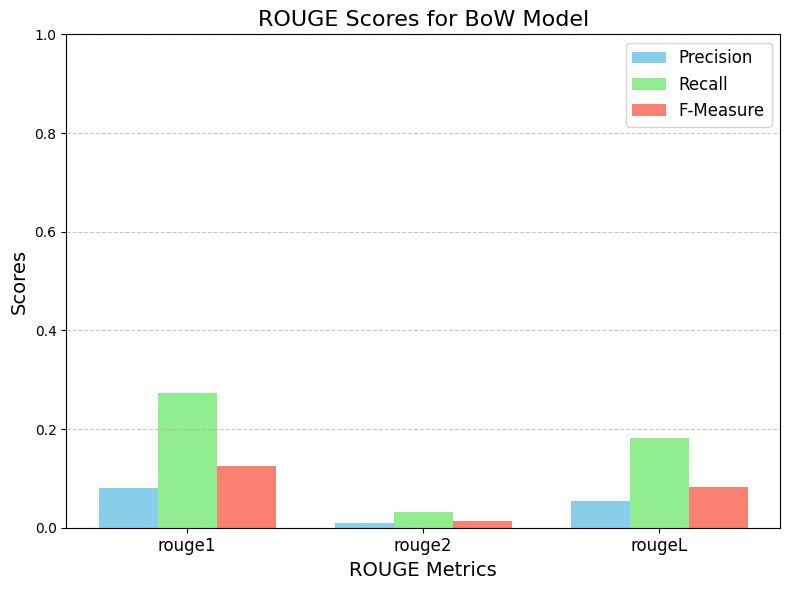

In [188]:
def plot_rouge_BoW(rouge_scores):
    metrics = ['rouge1', 'rouge2', 'rougeL']
    precision = [rouge_scores[metric].precision for metric in metrics]
    recall = [rouge_scores[metric].recall for metric in metrics]
    fmeasure = [rouge_scores[metric].fmeasure for metric in metrics]

    # Set up the bar width and positions
    bar_width = 0.25
    x = np.arange(len(metrics))  # Positions for the bars

    # Plot the bars
    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
    plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
    plt.bar(x + bar_width, fmeasure, width=bar_width, label='F-Measure', color='salmon')

    # Add labels and title
    plt.xticks(x, metrics, fontsize=12)
    plt.xlabel("ROUGE Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("ROUGE Scores for BoW Model", fontsize=16)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_rouge_BoW(Calculate_Rouge_Bow(Bow_summary,original_summary))


#### **TF - IDF**

In [189]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#  TF-IDF
def summarize_with_tfidf(article_text, num_sentences=5):
    # Split article into sentences
    sentences = nltk.sent_tokenize(article_text)
    # Preprocess sentences
    processed_sentences = [preprocess_text(sentence) for sentence in sentences]

    # Vectorize sentences using TF-IDF
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(processed_sentences)

    # similarity matrix
    similarity_matrix = cosine_similarity(sentence_vectors)

    # Rank sentences by similarity scores
    sentence_scores = similarity_matrix.sum(axis=1)
    ranked_sentences = np.argsort(sentence_scores)[::-1]

    # Select top sentences
    selected_sentences = [sentences[i] for i in ranked_sentences[:num_sentences]]
    summary = " ".join(selected_sentences)
    return summary

# Generate summary
example_article = data_samples[1]["article"]
start_time = time.time()
summary = summarize_with_tfidf(example_article)
end_time = time.time()
TF_IDF_Inference_time = end_time - start_time
Inference_times['TF-IDF'] = TF_IDF_Inference_time
print(f"Time taken: {end_time - start_time} seconds")
# print("Original Article:", example_article)
print("Generated Summary:", summary)

Time taken: 0.006497859954833984 seconds
Generated Summary: Ferguson, whose double somersault horror fall from the favourite Merrion Square in the 4.20pm at Wincanton on Wednesday has been watched hundreds of thousands of times online. Jockey Lewis Ferguson, 18, who survived a spectacular fall from Merrion Square shows off the cut on his nose . Ferguson, whose double somersault horror fall has been watched by hundreds of thousands online . There was no special treatment for Lewis Ferguson at Paul Nicholls’ yard on Thursday morning. The 18-year-old was mucking out the stables as usual, just a cut on the nose to show for the fall which has made him an internet sensation.


In [190]:
def Calculate_Rouge_TFIDF(TFIDF_summary,Original_summary):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  scores= scorer.score(Original_summary, TFIDF_summary)
  return scores

In [191]:
TF_IDF_summary = summarize_with_tfidf(example_article)
Calculate_Rouge_TFIDF(TF_IDF_summary,original_summary)

{'rouge1': Score(precision=0.06666666666666667, recall=0.21212121212121213, fmeasure=0.10144927536231883),
 'rouge2': Score(precision=0.009615384615384616, recall=0.03125, fmeasure=0.014705882352941176),
 'rougeL': Score(precision=0.05714285714285714, recall=0.18181818181818182, fmeasure=0.08695652173913043)}

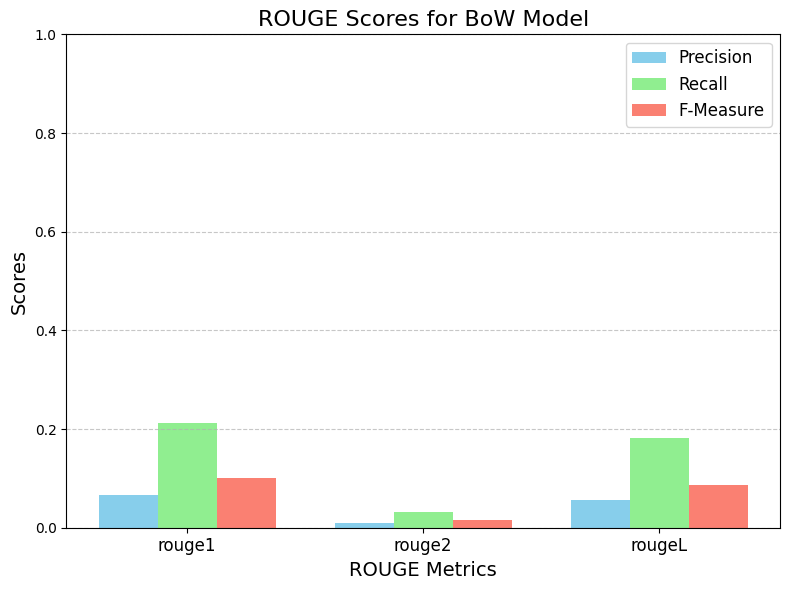

In [192]:
def plot_rouge_TFIDF(rouge_scores):
    metrics = ['rouge1', 'rouge2', 'rougeL']
    precision = [rouge_scores[metric].precision for metric in metrics]
    recall = [rouge_scores[metric].recall for metric in metrics]
    fmeasure = [rouge_scores[metric].fmeasure for metric in metrics]

    # Set up the bar width and positions
    bar_width = 0.25
    x = np.arange(len(metrics))  # Positions for the bars

    # Plot the bars
    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
    plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
    plt.bar(x + bar_width, fmeasure, width=bar_width, label='F-Measure', color='salmon')

    # Add labels and title
    plt.xticks(x, metrics, fontsize=12)
    plt.xlabel("ROUGE Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("ROUGE Scores for BoW Model", fontsize=16)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_rouge_TFIDF(Calculate_Rouge_TFIDF(TF_IDF_summary,original_summary))


#### **T5 (Text-to-Text Transfer Transformer)**

In [193]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
import numpy as np

In [194]:
cnn_dailymail = load_dataset("cnn_dailymail", "1.0.0")
sampled_dataset = cnn_dailymail["train"].select(range(30000))
cnn_dailymail = sampled_dataset.train_test_split(test_size=0.2)
checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [195]:
def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    labels = tokenizer(text_target=examples["highlights"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [196]:
tokenized_cnn_dailymail = cnn_dailymail.map(preprocess_function, batched=True)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)
rouge = evaluate.load("rouge")
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [197]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    print("Sample Predictions:", decoded_preds[:3])  # Log some predictions
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/models",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,

)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_cnn_dailymail["train"],
    eval_dataset=tokenized_cnn_dailymail["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,

)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [198]:
model_name = "/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/models/checkpoint-4500"  # Replace with your checkpoint's model path
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [199]:
def summerize_with_T5(article_text):
    inputs = tokenizer(article_text, return_tensors="pt", max_length=1024, truncation=True)
    start_time = time.time()
    outputs = model.generate(
          **inputs,
          max_length=512,
          early_stopping=True,
          temperature=0.8,
          top_k=70,
          top_p=0.8,
          num_beams=4,
      )
    end_time = time.time()
    T5_inference_time = end_time - start_time
    print(f"Time taken: {T5_inference_time} seconds")
    Inference_times['T5'] = T5_inference_time
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary

In [200]:
def Calculate_Rouge_T5(T5_summary,Original_summary):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  scores = scorer.score(Original_summary, T5_summary)
  return scores

In [201]:
T5_Summary = summerize_with_T5(example_article)
print(Calculate_Rouge_T5(T5_Summary,original_summary))
print(T5_Summary)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `70` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Time taken: 7.6616692543029785 seconds
{'rouge1': Score(precision=0.1951219512195122, recall=0.24242424242424243, fmeasure=0.2162162162162162), 'rouge2': Score(precision=0.025, recall=0.03125, fmeasure=0.02777777777777778), 'rougeL': Score(precision=0.14634146341463414, recall=0.18181818181818182, fmeasure=0.16216216216216217)}
Jockey Lewis Ferguson, 18, survived a spectacular fall from Merrion Square. The amateur jockey was mucking out the stables as usual at Paul Nicholls’ yard. He was back riding out and said he was undeterred from getting back in the sadal.


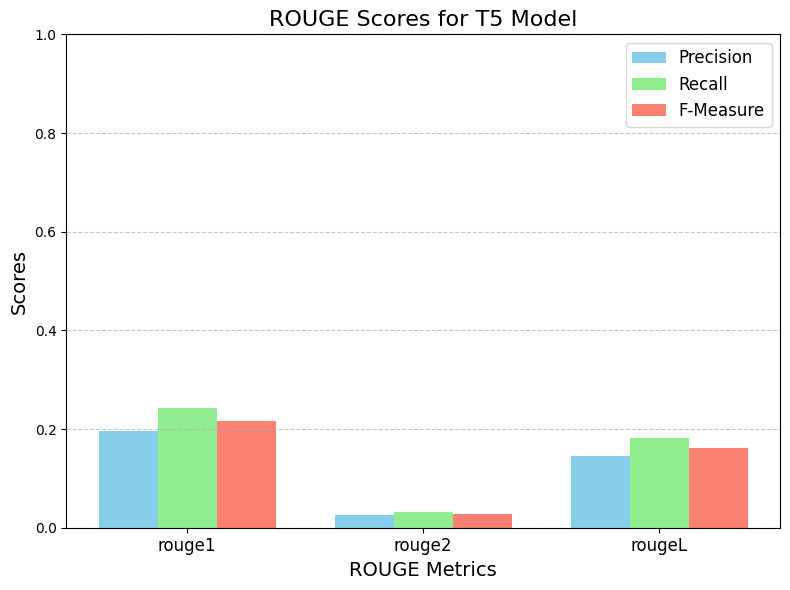

In [202]:
def plot_rouge_T5(rouge_scores):
    metrics = ['rouge1', 'rouge2', 'rougeL']
    precision = [rouge_scores[metric].precision for metric in metrics]
    recall = [rouge_scores[metric].recall for metric in metrics]
    fmeasure = [rouge_scores[metric].fmeasure for metric in metrics]

    # Set up the bar width and positions
    bar_width = 0.25
    x = np.arange(len(metrics))  # Positions for the bars

    # Plot the bars
    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
    plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
    plt.bar(x + bar_width, fmeasure, width=bar_width, label='F-Measure', color='salmon')

    # Add labels and title
    plt.xticks(x, metrics, fontsize=12)
    plt.xlabel("ROUGE Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("ROUGE Scores for T5 Model", fontsize=16)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_rouge_T5(Calculate_Rouge_T5(T5_Summary,original_summary))


#### **BERT - Bidirectional Encoder Representations From Transformers**

In [203]:
%%capture
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("patrickvonplaten/bert2bert_cnn_daily_mail")
model = AutoModelForSeq2SeqLM.from_pretrained("patrickvonplaten/bert2bert_cnn_daily_mail")

Config of the encoder: <class 'transformers.models.bert.modeling_bert.BertModel'> is overwritten by shared encoder config: BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "return_dict": false,
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Config of the decoder: <class 'transformers.models.bert.modeling_bert.BertLMHeadModel'> is overwritten by shared decoder config: BertConfig {
  "_name_or_path": "bert-base-uncased",
  "add_cross_attention"

In [204]:
import datasets
test_data = datasets.load_dataset("cnn_dailymail", "1.0.0", split="test[:2%]")

In [205]:
from transformers import EncoderDecoderModel
bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [206]:
def summerize_with_BERT(article_text):
    # Tokenize the input article
    inputs = tokenizer(article_text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    device = next(model.parameters()).device  # Get model's device
    inputs = inputs.to(device)

    # Explicitly set the decoder_start_token_id if it's not already defined
    if model.config.decoder_start_token_id is None:
        model.config.decoder_start_token_id = tokenizer.cls_token_id  # or tokenizer.bos_token_id

    start_time = time.time()
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=150,          # Max length of the generated summary
        num_beams=4,             # Beam search for quality improvement
        length_penalty=2.0,      # Encourage shorter summaries
        no_repeat_ngram_size=3,  # Avoid repetition
        early_stopping=True,
    )
    end_time = time.time()
    print(f"Time taken: {end_time - start_time} seconds")
    BERT_inference_time = end_time - start_time
    Inference_times['BERT'] = BERT_inference_time
    # Decode the generated summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [207]:
def Calculate_Rouge_BERT(BERT_summary,Original_summary):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  scores = scorer.score(Original_summary, BERT_summary)
  return scores

In [208]:
BERT_Summary =  summerize_with_BERT(example_article)
print(Calculate_Rouge_BERT(BERT_Summary,original_summary))
print(BERT_Summary)

Time taken: 14.651209354400635 seconds
{'rouge1': Score(precision=0.10909090909090909, recall=0.18181818181818182, fmeasure=0.13636363636363638), 'rouge2': Score(precision=0.018518518518518517, recall=0.03125, fmeasure=0.023255813953488372), 'rougeL': Score(precision=0.07272727272727272, recall=0.12121212121212122, fmeasure=0.0909090909090909)}
lewis ferguson was mucking out the stables as usual, just a cut on the nose to show for the fall which has made him an internet sensation. the 18 - year - old's double somersault fall from merrion square in the 4. 20pm at wincanton on wednesday has been watched hundreds of thousands of times online.


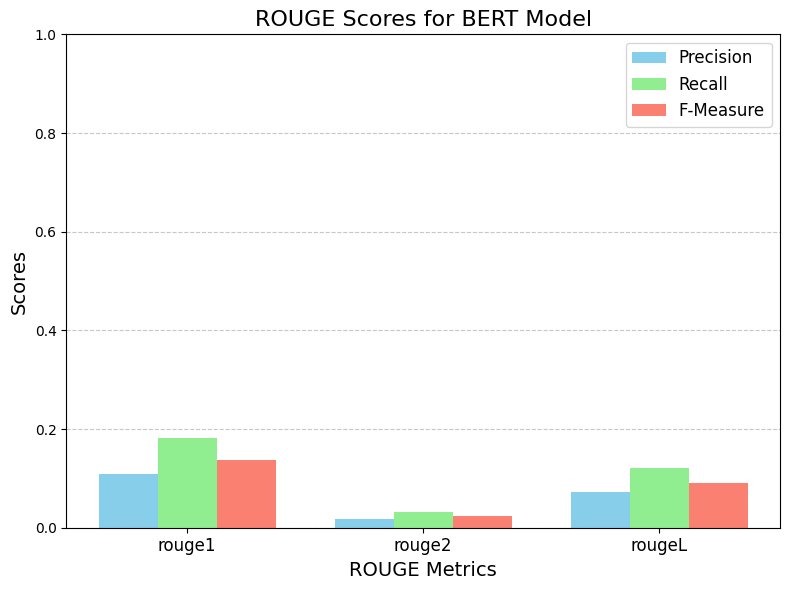

In [210]:
def plot_rouge_BERT(rouge_scores):
    metrics = ['rouge1', 'rouge2', 'rougeL']
    precision = [rouge_scores[metric].precision for metric in metrics]
    recall = [rouge_scores[metric].recall for metric in metrics]
    fmeasure = [rouge_scores[metric].fmeasure for metric in metrics]

    # Set up the bar width and positions
    bar_width = 0.25
    x = np.arange(len(metrics))  # Positions for the bars

    # Plot the bars
    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
    plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
    plt.bar(x + bar_width, fmeasure, width=bar_width, label='F-Measure', color='salmon')

    # Add labels and title
    plt.xticks(x, metrics, fontsize=12)
    plt.xlabel("ROUGE Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("ROUGE Scores for BERT Model", fontsize=16)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_rouge_BERT(Calculate_Rouge_BERT(BERT_Summary,original_summary))


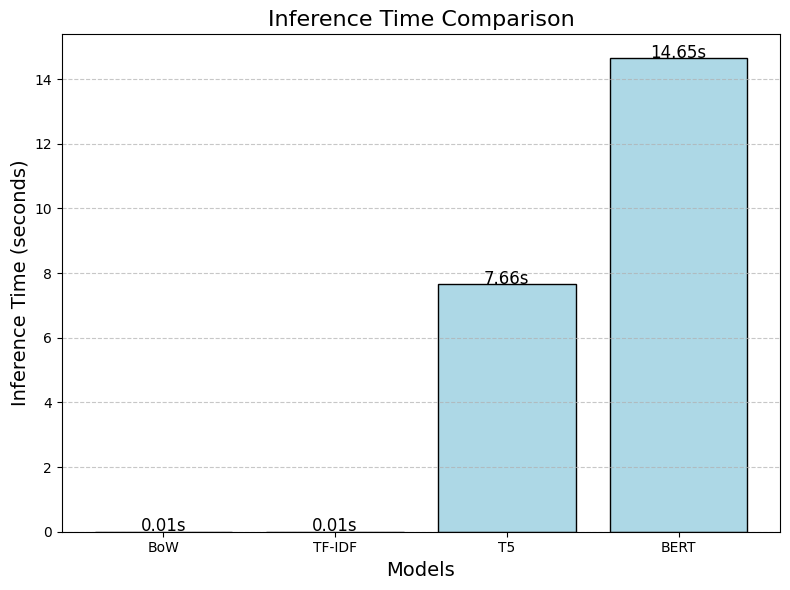

In [211]:
def plot_inference_times_from_dict(inference_times_dict):

    # Extract the model names (keys) and their corresponding inference times (values)
    models = list(inference_times_dict.keys())
    inference_times = list(inference_times_dict.values())

    # Create the bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(models, inference_times, color='lightblue', edgecolor='black')

    # Add titles and labels
    plt.title("Inference Time Comparison", fontsize=16)
    plt.xlabel("Models", fontsize=14)
    plt.ylabel("Inference Time (seconds)", fontsize=14)

    # Annotate the bars with the actual inference times
    for i, time in enumerate(inference_times):
        plt.text(i, time + 0.01, f"{time:.2f}s", ha='center', fontsize=12)

    # Customize the grid and layout
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_inference_times_from_dict(Inference_times)